In [1]:
import pandas as pd

# Carga directa desde GitHub usando raw URL
url = "https://github.com/JeancarloSZR/Reto3/raw/main/BD_6P%20ENLA%20muestral%202024.xlsx"
df = pd.read_excel(url)

# Vista previa
print("Dimensiones del dataset:", df.shape)
df.head()


Dimensiones del dataset: (105534, 21)


,ID_IE,ID_SECCION,cor_est,cod_DRE,nom_dre,cod_UGEL,nom_ugel,codgeo,departamento,provincia,...,gestion2,area,sexo,M500_EM_6P_2024_CT,grupo_EM_6P_2024_CT,M500_EM_6P_2024_MA,grupo_EM_6P_2024_MA,peso_Lectura,peso_Mate,Estrato_DRE
0,1808,2,3,800,Cusco,80002,Acomayo,80201,CUSCO,ACOMAYO,...,1,1,1,479.153,2.0,507.684,2.0,8.585908,8.585908,8001
1,1808,2,4,800,Cusco,80002,Acomayo,80201,CUSCO,ACOMAYO,...,1,1,1,470.146,2.0,413.986,1.0,8.585908,8.585908,8001
2,1808,2,5,800,Cusco,80002,Acomayo,80201,CUSCO,ACOMAYO,...,1,1,1,469.963,2.0,419.353,1.0,8.585908,8.585908,8001
3,1808,2,6,800,Cusco,80002,Acomayo,80201,CUSCO,ACOMAYO,...,1,1,2,447.932,2.0,419.988,1.0,8.585908,8.585908,8001
4,1808,2,7,800,Cusco,80002,Acomayo,80201,CUSCO,ACOMAYO,...,1,1,1,519.260,2.0,549.413,3.0,8.585908,8.585908,8001


In [2]:
from sklearn.preprocessing import LabelEncoder

# Identificar columnas categóricas
cat_cols = df.select_dtypes(include='object').columns.tolist()
print("Variables categóricas:", cat_cols)

# Codificación label para columnas categóricas
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Eliminación de columnas que puedan generar leakage
df = df.drop(columns=['M500_EM_6P_2024_MA'], errors='ignore')


Variables categóricas: ['nom_dre', 'nom_ugel', 'departamento', 'provincia', 'distrito']


In [3]:
# Variable objetivo ordinal
y = df['grupo_EM_6P_2024_MA']

# Predictores
X = df.drop(columns=['grupo_EM_6P_2024_MA'])

# Distribución de clases
print("Distribución por clase de la variable dependiente:")
print(y.value_counts().sort_index())


Distribución por clase de la variable dependiente:
grupo_EM_6P_2024_MA
1.0    18338
2.0    40245
3.0    30053
4.0    14886
Name: count, dtype: int64


In [5]:
# Variable objetivo ordinal
y = df['grupo_EM_6P_2024_MA']

# Predictores
X = df.drop(columns=['grupo_EM_6P_2024_MA'])

# Combinar X e y para eliminar filas con NaN en y
# Esto asegura que X e y se alineen después de la eliminación
df_combined = pd.concat([X, y], axis=1)
df_combined.dropna(subset=['grupo_EM_6P_2024_MA'], inplace=True)

# Separar X e y de nuevo después de eliminar las filas con NaN
X = df_combined.drop(columns=['grupo_EM_6P_2024_MA'])
y = df_combined['grupo_EM_6P_2024_MA']


# Distribución de clases después de eliminar NaN
print("Distribución por clase de la variable dependiente después de eliminar NaN:")
print(y.value_counts().sort_index())

# %%
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y, # stratify should work now as y has no NaNs
    random_state=42
)

Distribución por clase de la variable dependiente después de eliminar NaN:
grupo_EM_6P_2024_MA
1.0    18338
2.0    40245
3.0    30053
4.0    14886
Name: count, dtype: int64


In [6]:
from sklearn.ensemble import RandomForestClassifier

# Modelo inicial
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

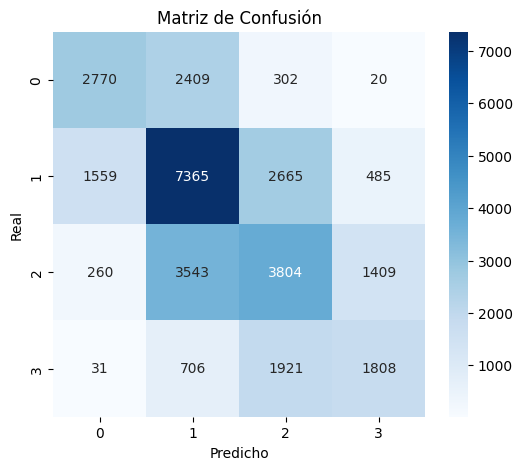

              precision    recall  f1-score   support

         1.0       0.60      0.50      0.55      5501
         2.0       0.53      0.61      0.56     12074
         3.0       0.44      0.42      0.43      9016
         4.0       0.49      0.40      0.44      4466

    accuracy                           0.51     31057
   macro avg       0.51      0.49      0.50     31057
weighted avg       0.51      0.51      0.50     31057



In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = rf.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Reporte
print(classification_report(y_test, y_pred))


In [8]:
from sklearn.metrics import cohen_kappa_score, mean_absolute_error

kappa_w = cohen_kappa_score(y_test, y_pred, weights='quadratic')
mae = mean_absolute_error(y_test, y_pred)

print("Kappa ponderado (cuadrático):", round(kappa_w, 3))
print("MAE (error absoluto medio):", round(mae, 3))


Kappa ponderado (cuadrático): 0.591
MAE (error absoluto medio): 0.553
